# **Download the dataset**
首先先下載需要用到的資料，解壓縮後資料夾內的結構如下
```
finalProject/
|----train/train
    |----7b1c3f70760d2fc744d6fcebfa34d374.jpg
    |----7b1fdeeff00ce7b316a9d61b435ab7fe.jpg
    ...
|----unlabeled_data
    |----AafJpnHwok6965511956.jpg
    |----AaFWonxFbM4044591286.jpg
    ...
|----test/test
    |----000d70d25191ad64f00ca88a227c5985.jpg
    |----00a114110ac6f96c5ac10e792db5197f.jpg
    ...
|----train_data.csv
|----val_data.csv
```
Training data總共有9297筆   
Testing data總共有2800筆  

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --id 1U5KGRFT8gTix3eL1hvCxTojcNRuoN5RQ --output "data.zip"
!unzip -q "data.zip"

Downloading...
From: https://drive.google.com/uc?id=1U5KGRFT8gTix3eL1hvCxTojcNRuoN5RQ
To: /content/data.zip
100% 1.16G/1.16G [00:08<00:00, 144MB/s]


# **Import Packages**

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import DatasetFolder
from torchvision.transforms import AutoAugmentPolicy
from torch import optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import tensorflow as tf
import csv
import pandas as pd

### 固定 random seed

In [ ]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
same_seeds(87)

# **Dataset, Data Loader, and Transforms**
Reference:  
https://blog.csdn.net/weixin_41469023/article/details/115375927  
https://www.itread01.com/content/1544541602.html 

In [ ]:
train = pd.read_csv('train_data.csv')
train.head()

,Name,Type
0,0008f9900bf79699df6ac0bfc9349aeb.jpg,0
1,00210c557ada0872409a20827c315e0e.jpg,0
2,00279b6610632647813f91726535579f.jpg,0
3,0029ffb665491982905b3cd8b22ab1d9.jpg,3
4,003089e598e7298cb662b16624770a21.jpg,0


In [ ]:
train_file = train["Name"]
train_file = [os.path.join("train/train/",i) for i in train_file]

train_label = train["Type"]
label_train = []
for i in range(len(train_label)):
    label_train.append(train_label[i])
print(label_train)

[0, 0, 0, 3, 0, 0, 3, 0, 1, 3, 0, 3, 0, 0, 3, 0, 2, 0, 0, 1, 3, 0, 2, 0, 3, 0, 0, 1, 1, 2, 3, 1, 2, 3, 1, 1, 0, 2, 3, 2, 2, 3, 0, 0, 0, 0, 0, 3, 3, 0, 1, 3, 3, 1, 0, 0, 3, 0, 1, 3, 2, 2, 1, 2, 0, 0, 3, 2, 3, 3, 0, 3, 3, 3, 0, 2, 0, 0, 1, 1, 0, 3, 2, 0, 3, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 0, 0, 0, 3, 1, 0, 1, 3, 2, 1, 2, 2, 0, 0, 3, 3, 0, 0, 3, 1, 0, 3, 3, 0, 0, 3, 3, 1, 0, 0, 2, 3, 2, 3, 3, 3, 0, 1, 0, 3, 3, 0, 3, 0, 3, 3, 2, 0, 3, 1, 3, 1, 0, 2, 3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 3, 0, 0, 3, 3, 3, 1, 2, 3, 3, 0, 0, 0, 1, 3, 0, 3, 2, 1, 1, 3, 1, 3, 3, 0, 0, 0, 0, 2, 2, 2, 3, 2, 0, 2, 3, 2, 2, 3, 3, 3, 1, 3, 3, 2, 0, 2, 2, 3, 2, 0, 0, 3, 0, 0, 0, 0, 2, 2, 2, 1, 3, 1, 3, 3, 1, 2, 3, 2, 1, 0, 0, 2, 2, 1, 0, 0, 3, 1, 3, 1, 0, 3, 3, 3, 0, 2, 3, 3, 0, 2, 0, 2, 0, 1, 0, 0, 0, 3, 2, 2, 0, 3, 0, 0, 0, 1, 0, 0, 2, 3, 0, 0, 2, 1, 0, 0, 0, 3, 2, 3, 3, 2, 0, 2, 2, 2, 0, 1, 3, 2, 0, 2, 0, 2, 3, 3, 2, 2, 0, 1, 0, 3, 3, 3, 1, 3, 1, 3, 3, 2, 2, 2, 3, 2, 3, 3, 0, 3, 0, 0, 1, 

In [ ]:
class IMAGE(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        if root == 'train/train/':
            self.filenames = train_file
            self.target = label_train
        if root == 'unlabeled_data/':
            self.filenames = glob.glob(os.path.join(root,'*'))
            self.target = [0 for i in range(len(self.filenames))]     
        if root == 'test/test/':
            self.filenames = glob.glob(os.path.join(root,'*'))
            self.target = [0 for i in range(len(self.filenames))]
        self.len = len(self.filenames)
    def __getitem__(self, index):
        image_fn = self.filenames[index]
        image = Image.open(image_fn)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = self.target[index]
        if self.transform is not None:
            image = self.transform(image)
        image = image.resize_([3, 256, 256])
        return image, label
    def __len__(self):
        return self.len

## Data Augmentation
對現有圖片進行平移、翻轉、旋轉、改變明度對比度等方式來增加資料集

In [ ]:
randomAugment = [transforms.ColorJitter(0.1, 0.1, 0.1), transforms.ColorJitter(0.2, 0.2, 0.2)]
autoAugment = [transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
         transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
         transforms.AutoAugment(policy=AutoAugmentPolicy.SVHN)]

train_tfm1 = transforms.Compose([
	transforms.Resize((256, 256)),
  # transforms.Resize((128, 128)),
  transforms.RandomChoice(randomAugment),
  transforms.RandomHorizontalFlip(p=0.7),
	transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_tfm2 = transforms.Compose([
	transforms.Resize((256, 256)),
  # transforms.Resize((128, 128)),
  transforms.RandomChoice(randomAugment),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
  transforms.RandomAffine(degrees=30, translate=(0.12, 0.12), scale=(0.8, 1.2)),
  # transforms.RandomApply(transform_set, p=0.7),
	transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_tfm3 = transforms.Compose([
	transforms.Resize((256, 256)),
  # transforms.Resize((128, 128)),
  transforms.RandomChoice(randomAugment),
  transforms.RandomHorizontalFlip(p=0.7),
  transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
  transforms.RandomAffine(degrees=45, translate=(0.12, 0.12), scale=(0.8, 1.2)),
	transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_tfm4 = transforms.Compose([
	transforms.Resize((256, 256)),
  # transforms.Resize((128, 128)),
  transforms.RandomChoice(randomAugment),
  transforms.RandomHorizontalFlip(p=0.8),
  transforms.AutoAugment(policy=AutoAugmentPolicy.SVHN),
  transforms.RandomAffine(degrees=60, translate=(0.12, 0.12), scale=(0.8, 1.2)),
	transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_tfm5 = transforms.Compose([
	transforms.Resize((256, 256)),
  # transforms.Resize((128, 128)),
  # transforms.RandomChoice(randomAugment),
  transforms.ColorJitter(0.3, 0.2, 0.15),
  # transforms.GaussianBlur(5),
  transforms.RandomHorizontalFlip(p=0.6),
  transforms.AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
	transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.Resize((128, 128)),
    # transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Load Data
把所有資料包裝好之後載下來

In [ ]:
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set1 = IMAGE("train/train/", transform=train_tfm1)
train_set2 = IMAGE("train/train/", transform=train_tfm2)
train_set3 = IMAGE("train/train/", transform=train_tfm3)
train_set4 = IMAGE("train/train/", transform=train_tfm4)
train_set5 = IMAGE("train/train/", transform=train_tfm5)
train_set = ConcatDataset([train_set1, train_set2, train_set3, train_set4, train_set5])

unlabeled_set1 = IMAGE("unlabeled_data/", transform=train_tfm1)
unlabeled_set2 = IMAGE("unlabeled_data/", transform=train_tfm2)
unlabeled_set3 = IMAGE("unlabeled_data/", transform=train_tfm3)
unlabeled_set4 = IMAGE("unlabeled_data/", transform=train_tfm4)
unlabeled_set5 = IMAGE("unlabeled_data/", transform=train_tfm5)
unlabeled_set = ConcatDataset([unlabeled_set1, unlabeled_set2, unlabeled_set3, unlabeled_set4, unlabeled_set5])

train_set, validation_set = data.random_split(train_set, [8279*5, 5000])
test_set = IMAGE("test/test/", transform=test_tfm)

print('# images in trainset:', len(train_set)) 
print('# images in validationset:', len(validation_set))
# print('# images in unlabeledset:', len(unlabeled_set))
print('# images in testset:', len(test_set))

# Construct data loaders.
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)

# images in trainset: 41395
# images in validationset: 5000
# images in testset: 2800
Image tensor in each batch: torch.Size([32, 3, 256, 256]) torch.float32
Label tensor in each batch: torch.Size([32]) torch.int64


看一下要train的圖片，確認做完data augmentation後的圖片合不合理

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:
tensor(3) tensor(1) tensor(1) tensor(1) tensor(3) tensor(0) tensor(0) tensor(1) tensor(2) tensor(3) tensor(3) tensor(0) tensor(1) tensor(3) tensor(0) tensor(0)


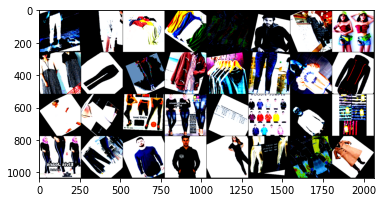

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:')
print(' '.join('%5s' % labels[j] for j in range(16)))

# **Model**

In [ ]:
# 看一下哪一種GPU，不過現在免費版的只剩下超爛的K80
use_cuda = torch.cuda.is_available()
torch.manual_seed(87)
device = torch.device("cuda" if use_cuda else "cpu")
print('Device used:', device)
!nvidia-smi

Device used: cuda
Tue Jan  4 04:59:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    75W / 149W |    600MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                      

In [ ]:
import torchvision.models as models 
model = models.efficientnet_b4(pretrained=True).to(device)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_features=1792, out_features=4, bias=True),
    ).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth


  0%|          | 0.00/74.5M [00:00<?, ?B/s]

In [ ]:
print(model)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

# **Training**

In [ ]:
from tqdm.auto import tqdm

In [ ]:
class PSEUDO(Dataset):
  def __init__(self, x, y):
      super().__init__()
      self.x = x
      self.y = y
      self.len = len(self.x)
  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.len

In [ ]:
def get_pseudo_labels(dataset, model, threshold):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    softmax = nn.Softmax(dim=-1)
    predictions = [[] for i in range(4)]
    Type_rec = np.zeros([4])
    model.eval()

    for batch in tqdm(data_loader):
        img, _ = batch
        with torch.no_grad():
            logits = model(img.to(device))
        probs = softmax(logits)

        for i in range(img.shape[0]):
            _ , Type = torch.max(probs[i], 0)
            Type = int(Type.item())
            if probs[i][Type].item() >= threshold:
                predictions[Type].append(img[i])
                Type_rec[Type] += 1

    ret_predictions = []
    type_list = []

    for i in range(4):
        for j in predictions[i]:
            ret_predictions.append(j)
            type_list.append(i)

    print('Added %d images' %(len(type_list)))
    return PSEUDO(ret_predictions, type_list)

In [ ]:
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
n_epochs = 3
best_acc = 0
do_semi = False
threshold = 0.98
# checkpoint = torch.load('drive/MyDrive/model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

for epoch in range(n_epochs):
    if do_semi:
        pseudo_set = get_pseudo_labels(unlabeled_set, model, threshold)
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    #start training
    model.train()
    train_loss = []
    train_accs = []
    for batch in tqdm(train_loader):
        imgs, labels = batch
        logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        # loss = checkpoint['loss']
        optimizer.zero_grad()
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    model.eval()
    valid_loss = []
    valid_accs = []
    for batch in tqdm(valid_loader):
        imgs, labels = batch
        with torch.no_grad():
          logits = model(imgs.to(device))
        loss = criterion(logits, labels.to(device))
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save({
          'optimizer_state_dict': optimizer.state_dict(),
          'model_state_dict': model.state_dict(),
          'loss': loss
          },'model.pt')
        print('model saved')
    # if valid_acc > 0.82:
    #     do_semi = True
    # if valid_acc < 0.7:
    #     do_semi = False

  0%|          | 0/259 [00:00<?, ?it/s]

[ Train | 001/003 ] loss = 0.78994, acc = 0.69747


  0%|          | 0/32 [00:00<?, ?it/s]

[ Valid | 001/003 ] loss = 0.55843, acc = 0.81445
model saved


  0%|          | 0/165 [00:00<?, ?it/s]

Added 220 images


  0%|          | 0/266 [00:00<?, ?it/s]

[ Train | 002/003 ] loss = 0.47407, acc = 0.82918


  0%|          | 0/32 [00:00<?, ?it/s]

[ Valid | 002/003 ] loss = 0.49595, acc = 0.82031
model saved


  0%|          | 0/165 [00:00<?, ?it/s]

Added 684 images


  0%|          | 0/281 [00:00<?, ?it/s]

[ Train | 003/003 ] loss = 0.39420, acc = 0.85928


  0%|          | 0/32 [00:00<?, ?it/s]

[ Valid | 003/003 ] loss = 0.45223, acc = 0.84277
model saved


# **Method2: 用Torchensemble train**

In [ ]:
!pip install torchensemble

     |████████████████████████████████| 40 kB 3.3 MB/s 


In [ ]:
from torchensemble import VotingClassifier

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'DEVICE: {device}')
model_path = './model.ckpt'

model = VotingClassifier(estimator=model,n_estimators=3,cuda=True).to(device)
criterion = nn.CrossEntropyLoss() 
model.set_optimizer("Adam",lr=0.0001,weight_decay=1e-05)

DEVICE: cuda


In [ ]:
# start training
model.fit(train_loader,epochs=2)
torch.save(model.state_dict(), model_path)
print('saving model')

Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 1.41714 | Correct: 3/32
Estimator: 000 | Epoch: 000 | Batch: 100 | Loss: 1.01279 | Correct: 23/32
Estimator: 000 | Epoch: 000 | Batch: 200 | Loss: 0.72461 | Correct: 22/32
Estimator: 000 | Epoch: 000 | Batch: 300 | Loss: 0.62445 | Correct: 24/32
Estimator: 000 | Epoch: 000 | Batch: 400 | Loss: 0.54711 | Correct: 27/32
Estimator: 000 | Epoch: 000 | Batch: 500 | Loss: 0.44086 | Correct: 28/32
Estimator: 000 | Epoch: 000 | Batch: 600 | Loss: 0.33940 | Correct: 29/32
Estimator: 000 | Epoch: 000 | Batch: 700 | Loss: 0.79748 | Correct: 24/32
Estimator: 000 | Epoch: 000 | Batch: 800 | Loss: 0.37788 | Correct: 27/32
Estimator: 000 | Epoch: 000 | Batch: 900 | Loss: 0.27601 | Correct: 29/32
Estimator: 000 | Epoch: 000 | Batch: 1000 | Loss: 0.47750 | Correct: 27/32
Estimator: 000 | Epoch: 000 | Batch: 1100 | Loss: 0.50655 | Correct: 26/32
Estimator: 000 | Epoch: 000 | Batch: 1200 | Loss: 0.25718 | Correct: 29/32
Estimator: 001 | Epoch: 000 | Batch:

# **Prediction**

In [ ]:
model.eval()
filename_list = []
path = 'test/test/'

for infile in glob.glob(os.path.join(path,'*')):
  filename_list.append(infile[10:])
print(filename_list)
predictions = []

for batch in tqdm(test_loader):
    imgs, labels = batch
    with torch.no_grad():
        logits = model(imgs.to(device))
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

['7f58b1a0953d58cd079a6806474db804.jpg', 'e6fc7297cd2f5b93c8b5221a38effc51.jpg', 'a8e0e6ad9d108214132e9977eaba34d4.jpg', 'cb9b90c525afbe4c27c2afc0d7631c47.jpg', '006ef2a336bd15f53b50440837a847b2.jpg', '09b17ddc3dd876912148cfbdf1100e44.jpg', 'c043f98898d4c2cb3b7edf624336dfcf.jpg', '0ruobk7wi3pxys9mj1tad46f2l58hncg.jpg', '6ega3qu1zt2odwply8nhskfbi04r7v5c.jpg', '7oxt6nfueh5sivk4y1q3jrpdcmblz20a.jpg', 'f654fdb0969682878bb1606a5ed17baa.jpg', '63c635998965ed8f85f7f88ec880d644.jpg', '4fb9067tnkv2zajdu8goqh5eslx1wmcp.jpg', '397287c0a45cfedcc476ab41be74d6ff.jpg', '3rmg26zkc0ow7nf4h1usvjilq9exabtd.jpg', '4vu6p0oyaf32js5tmnz7b9rdlkqxcehi.jpg', '9f89d9582e4d811330e83e3628b84114.jpg', 'ad6d5c0fc4642d34fbff677c8997b1d8.jpg', '3dtnpe45879lyogjwubsicfaxhv621km.jpg', '5348546a86ba5b39192181c75648f4e8.jpg', 'dae0a66a9f7fb48aa418fbf4a6ed72fb.jpg', '2c286ab914bc7d8097c4b2c2d1910ad7.jpg', '59253504a2261821d1ad5050fe016ac8.jpg', 'b703b399cb3759fbaeb65f20210e6fc8.jpg', '2b577013696cf1b61f5e58276f5f3813.jpg',

  0%|          | 0/88 [00:00<?, ?it/s]

In [ ]:
with open("predict_ML_final.csv", "w") as f:
    f.write("Name,Type\n")
    for i, pred in  enumerate(predictions):
         f.write(f"{filename_list[i]},{pred}\n")

In [ ]:
from google.colab import files
files.download("predict_ML_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>